In [1]:
import cv2 as cv
import numpy as np
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr

from matplotlib import pyplot as plt

In [2]:
# image = cv.imread('character_pattern.tif', cv.IMREAD_GRAYSCALE)
image = cv.imread('dip.tif', cv.IMREAD_GRAYSCALE)

image = cv.resize(image, (512, 512))

print(image.dtype)
image.shape

uint8


(512, 512)

In [3]:
# # Add salt and pepper noise

# noisy_image = image.copy()
# noisy_image = random_noise(noisy_image, mode='s&p', amount=0.05) # 5% noise
# noisy_image = np.array(255 * noisy_image, dtype=np.uint8) # Convert to uint8

# # cv.imwrite('noisy_image.png', noisy_image)

# plt.imshow(noisy_image, cmap='gray')



# Function to add Salt and Pepper Noise

```python 
x = [np.random.randint(0, i-1, 5) for i in (50, 50)]
print(x)

'''output
[array([11, 16, 47,  8, 27], dtype=int32),
array([27, 41, 19, 24,  4], dtype=int32)]
'''
```

In [ ]:
def add_salt_and_pepper_noise(image, amount=0.05, salt_vs_pepper=0.5):
    """
    Add salt and pepper noise to an image.
    
    Parameters:
        image (numpy.ndarray): Input image.
        amount (float): Proportion of pixels to be replaced with noise.
        
    Returns:
        numpy.ndarray: Noisy image.
    """
    
    noisy = np.copy(image)
    total_pixels = noisy.size

    height, width = noisy.shape

    num_salt = int(amount * total_pixels * salt_vs_pepper)
    num_pepper = int(amount * total_pixels * (1.0 - salt_vs_pepper))


    # # add salt (white pixels)
    # coordinates = [np.random.randint(0, i-1, num_salt) for i in noisy.shape]
    # noisy[coordinates[0], coordinates[1]] = 255

    # # add pepper (black pixels)
    # coordinates = [np.random.randint(0, i-1, num_pepper) for i in noisy.shape]
    # noisy[coordinates[0], coordinates[1]] = 0

    # Add salt (white pixels)
    for _ in range(num_salt):
        x = np.random.randint(0, height)
        y = np.random.randint(0, width)
        noisy[x, y] = 255

    # Add pepper (black pixels)
    for _ in range(num_pepper):
        x = np.random.randint(0, height)
        y = np.random.randint(0, width)
        noisy[x, y] = 0

    return noisy



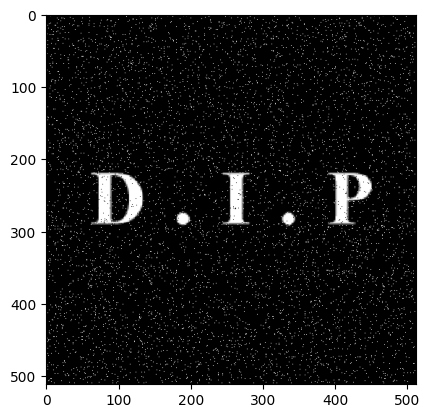

In [5]:
noisy_image = add_salt_and_pepper_noise(image, amount=0.05, salt_vs_pepper=0.5)

plt.imshow(noisy_image, cmap='gray')

# Function for Average filter

In [ ]:
# def average_filter(image, kernel_size):
#     return cv.blur(image, (kernel_size, kernel_size))


def average_filter(image, mask_size):
    """
    Apply average filter (mean filter) to the input image manually.
    
    Args:
        image (numpy array): Input grayscale image.
        mask_size (int): Size of the averaging mask (must be odd, like 3, 5, 7).
    
    Returns:
        numpy array: Filtered image.
    """
    # Ensure mask_size is odd
    if mask_size % 2 == 0:
        raise ValueError("Mask size must be an odd number.")
    
    # Padding
    pad = mask_size // 2
    padded_image = np.pad(image, pad, mode='reflect')
    
    # Prepare output image
    output = np.zeros_like(image, dtype=np.float64)
    
    # Average filter: kernel values are 1/(mask_size*mask_size)
    kernel_value = 1.0 / (mask_size * mask_size)
    
    # Convolve manually
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            block = padded_image[i:i+mask_size, j:j+mask_size]
            output[i, j] = np.sum(block) * kernel_value
    
    return np.clip(output, 0, 255).astype(np.uint8)


# Function for median filter

In [ ]:
# def median_filter(image, kernel_size):
#     return cv.medianBlur(image, kernel_size)

def median_filter(image, mask_size):
    """
    Apply median filter manually to the input image.
    
    Args:
        image (numpy array): Input grayscale image.
        mask_size (int): Size of the median mask (must be odd, like 3, 5, 7).
    
    Returns:
        numpy array: Median filtered image.
    """
    # Ensure mask_size is odd
    if mask_size % 2 == 0:
        raise ValueError("Mask size must be an odd number.")
    
    # Padding
    pad = mask_size // 2
    padded_image = np.pad(image, pad, mode='reflect')
    
    # Prepare output image
    output = np.zeros_like(image, dtype=np.float64)
    
    # Convolve manually
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            block = padded_image[i:i+mask_size, j:j+mask_size]
            output[i, j] = np.median(block)
    
    return np.clip(output, 0, 255).astype(np.uint8)


# Function for harmonic filter

In [8]:
def harmonic_filter(image, kernel_size):
    image = image.astype(np.float32) + 1e-5 # avoid division by zero

    height, width = image.shape
    pad = kernel_size // 2

    padded = cv.copyMakeBorder(image, pad, pad, pad, pad, cv.BORDER_REFLECT)

    result = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            result[i, j] = kernel_size * kernel_size / np.sum(1.0 / window)

    return np.clip(result, 0, 255).astype(np.uint8)

# Function for Geometric Mean filter

In [9]:
def geometric_mean_filter(image, kernel_size):
    image = image.astype(np.float32) + 1e-5 # avoid log(0)

    height, width = image.shape
    pad = kernel_size // 2

    padded = cv.copyMakeBorder(image, pad, pad, pad, pad, cv.BORDER_REFLECT)

    result = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            result[i, j] = np.exp(np.mean(np.log(window)))

    return np.clip(result, 0, 255).astype(np.uint8)

# Function for calculate Peak Signal-to-Noise Ratio

- It measures how good a processed image (e.g., noisy, filtered) is compared to the original (clean) image.
- Higher PSNR means better image quality → less difference (less error) between the original and the processed image.

In [ ]:
def calculate_psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float('inf')  # No error → Infinite PSNR
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

# --------------------------------(A)----------------------------------

# Apply average and median filter(noisy_image, 5)

In [ ]:
avg_5x5 = average_filter(noisy_image, 5)
med_5x5 = median_filter(noisy_image, 5)

psnr_avg_5x5 = calculate_psnr(image, avg_5x5)
psnr_med_5x5 = calculate_psnr(image, med_5x5)

print(f'PSNR of average filter (5x5): {psnr_avg_5x5:.2f}')
print(f'PSNR of median filter (5x5): {psnr_med_5x5:.2f}')

PSNR of average filter (5x5): 26.78
PSNR of median filter (5x5): 37.80


# --------------------------------(B)----------------------------------

# Apply average filter with 3x3, 5x5, 7x7

In [ ]:
for kernel_size in [3, 5, 7]:
    avg_image = average_filter(noisy_image, kernel_size)
    psnr_value = calculate_psnr(image, avg_image)
    print(f'PSNR of average filter ({kernel_size}x{kernel_size}): {psnr_value:.2f}')

PSNR of average filter (3x3): 24.63
PSNR of average filter (5x5): 26.78
PSNR of average filter (7x7): 26.73


# --------------------------------(C)----------------------------------

# Apply Harmonic Mean and Geometric Mean filters

In [ ]:
harmonic_image = harmonic_filter(noisy_image, 5)
geometric_image = geometric_mean_filter(noisy_image, 5)

psnr_harmonic = calculate_psnr(image, harmonic_image)
psnr_geometric = calculate_psnr(image, geometric_image)

print(f'PSNR of harmonic filter (5x5): {psnr_harmonic:.2f}')
print(f'PSNR of geometric mean filter (5x5): {psnr_geometric:.2f}')

PSNR of harmonic filter (5x5): 19.85
PSNR of geometric mean filter (5x5): 22.99


# show all images

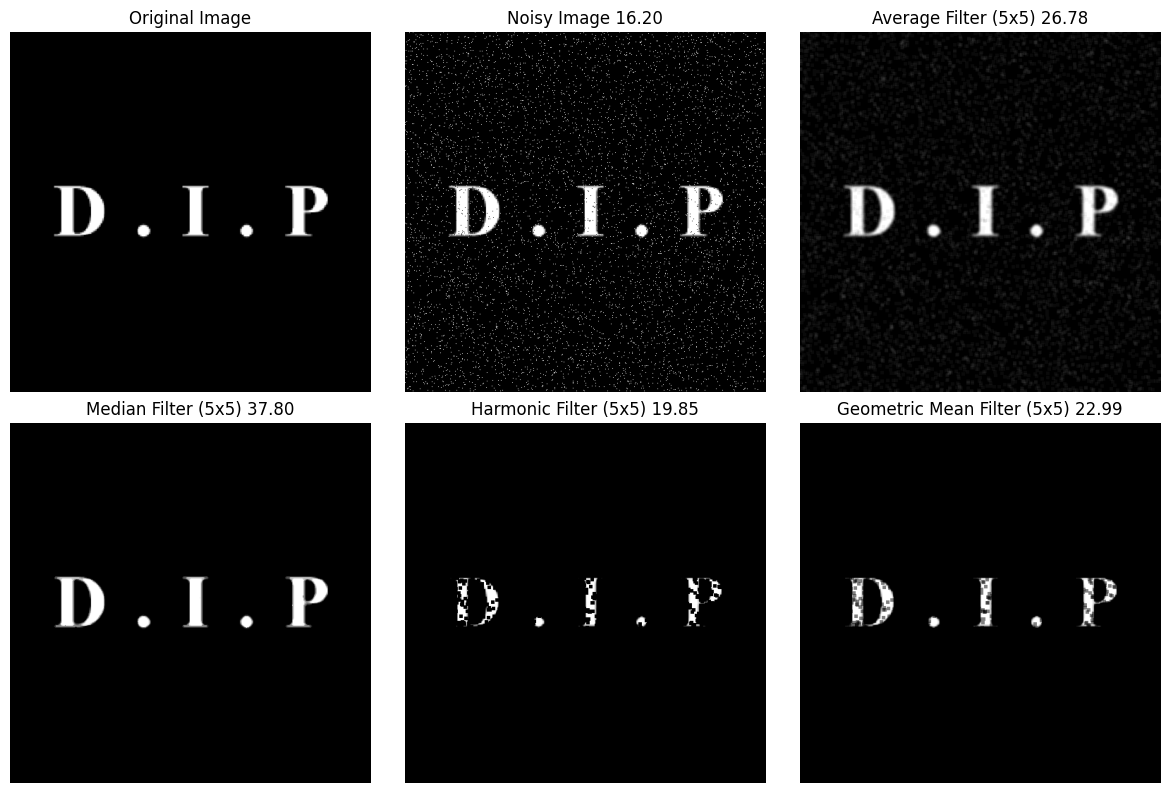

In [19]:
# show all images

plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image {psnr(image, noisy_image):.2f}')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(avg_5x5, cmap='gray')
plt.title(f'Average Filter (5x5) {psnr_avg_5x5:.2f}')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(med_5x5, cmap='gray')
plt.title(f'Median Filter (5x5) {psnr_med_5x5:.2f}')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(harmonic_image, cmap='gray')
plt.title(f'Harmonic Filter (5x5) {psnr_harmonic:.2f}')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(geometric_image, cmap='gray')
plt.title(f'Geometric Mean Filter (5x5) {psnr_geometric:.2f}')
plt.axis('off')
plt.tight_layout()
plt.show()
